Branje podatkov iz datotek in uvoz knjižnic:

In [3]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np


In [31]:
list_of_cvs = ["./podatki/kd{}.csv".format(i) for i in range(2010,2020)]
frames = [pd.read_csv(csv,sep=';', encoding="UTF-8", dtype={'MesecStoritve': str}) for csv in list_of_cvs]
df = pd.concat(frames)


C:\Users\Médo\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3301: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):
C:\Users\Médo\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3301: DtypeWarning: Columns (14,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


Količina vpletenih v posamezna kazniva dejanja:

min       1.000000
max     522.000000
mean      1.645663
dtype: float64


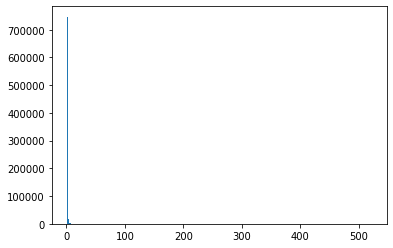

In [35]:
#Stevilo vpletenih v dejanje
size = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD'])
vpletenih = size.size()
print(vpletenih.agg(["min","max","mean"]))
plt.hist(vpletenih, bins=500)
plt.show()


Kazniva dejanja po mesecih:

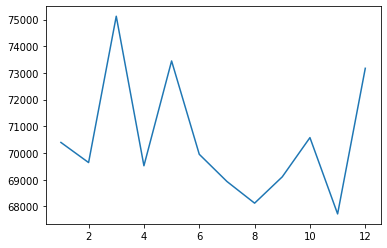

In [36]:
#group by mesec, count unique id
kd_mes = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD'])
mes_counter = defaultdict(int)

for name,v in kd_mes:
    #print(int(name[0].astype(str).split(".")[0]))
    mes_counter[int(name[0].astype(str).split(".")[0])] +=1


list_mes_counter = sorted(mes_counter.items())
mesec, counter = zip(*list_mes_counter)
plt.plot(mesec,counter)
plt.show()

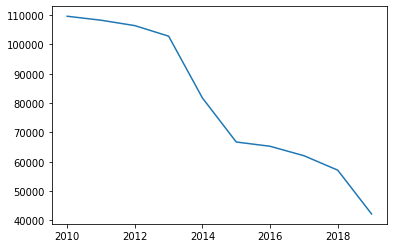

In [44]:
#group by mesec, count unique id
kd_mes = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD'])
mes_counter = defaultdict(int)

for name,v in kd_mes:
    index = int((name[0].split(".")[1]))
    if index >= 2010 and index < 2020:
        mes_counter[index] +=1
    


list_mes_counter = sorted(mes_counter.items())
mesec, counter = zip(*list_mes_counter)
plt.plot(mesec,counter)
plt.show()

Starostni razredi:


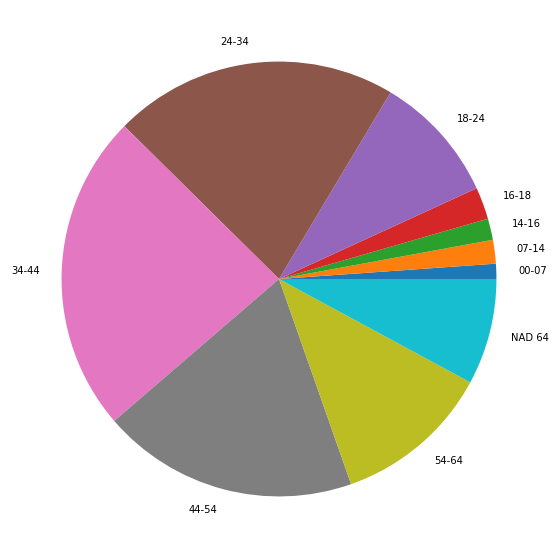

In [30]:
#razredi = df['StarostniRazred'].unique()
star_razredi = df.groupby(['StarostniRazred'])
star_razred, star_stevilo = zip(*[(name,razred.size) for name, razred in star_razredi])

plt.figure(figsize=(15,10))
plt.pie(star_stevilo[:-3], labels=star_razred[:-3])
plt.show()
